# Customer Analytics for a Telecom Provider

## Importing Libraries

In [1]:
# pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Loading & Reading Dataset

In [4]:
df = pd.read_csv("dataset/telecom_customer_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,CUST00001,Male,0,Yes,No,54,No,No phone service,Fiber optic,No internet service,Yes,No internet service,Yes,No internet service,No internet service,Two year,Yes,Mailed check,96.48,No
1,CUST00002,Female,0,No,No,35,Yes,No,No,Yes,No,Yes,Yes,No,No internet service,One year,No,Credit card (automatic),87.58,No
2,CUST00003,Male,0,Yes,No,36,Yes,No phone service,No,No internet service,No internet service,No internet service,Yes,Yes,Yes,Month-to-month,No,Bank transfer (automatic),79.78,No
3,CUST00004,Male,0,No,Yes,13,No,No phone service,Fiber optic,No,Yes,No,No,No internet service,No internet service,One year,Yes,Bank transfer (automatic),112.28,Yes
4,CUST00005,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No internet service,No internet service,Month-to-month,Yes,Mailed check,45.77,Yes


#### Info about data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5000 non-null   object 
 1   gender            5000 non-null   object 
 2   SeniorCitizen     5000 non-null   int64  
 3   Partner           5000 non-null   object 
 4   Dependents        5000 non-null   object 
 5   tenure            5000 non-null   int64  
 6   PhoneService      5000 non-null   object 
 7   MultipleLines     5000 non-null   object 
 8   InternetService   5000 non-null   object 
 9   OnlineSecurity    5000 non-null   object 
 10  OnlineBackup      5000 non-null   object 
 11  DeviceProtection  5000 non-null   object 
 12  TechSupport       5000 non-null   object 
 13  StreamingTV       5000 non-null   object 
 14  StreamingMovies   5000 non-null   object 
 15  Contract          5000 non-null   object 
 16  PaperlessBilling  5000 non-null   object 


#### Descriptive Statistics of data

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5000.0,0.498200,0.500047,0.0,0.0000,0.000,1.000,1.0
tenure,5000.0,35.828400,20.994340,0.0,17.7500,36.000,54.000,72.0
MonthlyCharges,5000.0,70.229976,27.907778,18.0,49.4375,70.185,90.895,120.0


In [7]:
df.describe(include=['object']).T

,count,unique,top,freq
customerID,5000,5000,CUST05000,1
gender,5000,2,Male,2504
Partner,5000,2,Yes,2508
Dependents,5000,2,No,2501
PhoneService,5000,2,No,2542
MultipleLines,5000,3,No phone service,1712
InternetService,5000,3,DSL,1782
OnlineSecurity,5000,3,No internet service,1740
OnlineBackup,5000,3,No,1690
DeviceProtection,5000,3,No,1755


In [8]:
df['Churn'].value_counts()

Churn
No     3652
Yes    1348
Name: count, dtype: int64

so, here data is imbalanced

In [9]:
df1 = df.copy()

## Data Cleaning

#### Dropping unnecessary column

In [10]:
df1.drop('customerID', axis=1, inplace=True, errors='ignore')

#### Finding Duplicates

In [11]:
df1.duplicated().any()

np.False_

**So, here are no duplicate entries.**

#### Finding Missing Values

In [12]:
# Remove leading/trailing whitespaces from all object columns.
# This helps detect hidden missing values like '   ' or 'NaN ' (with spaces), which are strings and not recognized as actual NaN by pandas.
for column in df1.select_dtypes(include=['object']).columns:
    df1[column] = df1[column].str.strip()

In [13]:
df1[df1['tenure'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
195,Female,0,Yes,No,0,No,No phone service,No,No,No,No,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),107.91,Yes
319,Female,1,No,No,0,Yes,No phone service,Fiber optic,No internet service,No internet service,No,No,No,No internet service,Month-to-month,No,Mailed check,120.00,Yes
623,Female,0,No,Yes,0,Yes,No,Fiber optic,No,No internet service,No internet service,No internet service,No internet service,Yes,One year,Yes,Bank transfer (automatic),80.98,Yes
739,Female,0,Yes,No,0,Yes,Yes,DSL,Yes,No internet service,No,No internet service,No internet service,Yes,Two year,Yes,Mailed check,40.03,No
800,Male,1,No,No,0,No,No,Fiber optic,No internet service,Yes,No,Yes,No,Yes,Two year,No,Mailed check,76.33,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4631,Male,1,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,Yes,No internet service,Yes,Month-to-month,No,Electronic check,73.71,Yes
4662,Male,1,Yes,Yes,0,Yes,Yes,No,No,No internet service,No,No,Yes,No internet service,One year,Yes,Bank transfer (automatic),47.75,Yes
4942,Female,1,No,Yes,0,Yes,No phone service,DSL,No,Yes,No,Yes,No,No internet service,Month-to-month,Yes,Credit card (automatic),47.32,No
4951,Female,1,No,No,0,No,No,Fiber optic,Yes,No,No internet service,No internet service,Yes,No,One year,No,Bank transfer (automatic),87.02,Yes


**69 records with 0 tenure**

In [14]:
# dropping records with 0 tenure
df1.drop(labels=df1[df1['tenure'] == 0].index, axis=0, inplace=True)

In [15]:
# checking missing values 
df1.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

**So, Here no missing values present.**

#### Dividing Categorical and Numerical Features (Excluding Target)

In [16]:
target_col = ['Churn']
numerical_cols = []
categorical_cols = []

separate_cat_num_cols = [categorical_cols.append(col) if df1[col].dtype == 'object' else numerical_cols.append(col) for col in df1.columns if col not in target_col]

In [17]:
numerical_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges']

In [18]:
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Finding Outliers

#### Finding outliers using boxplot in numerical columns

using seaborn

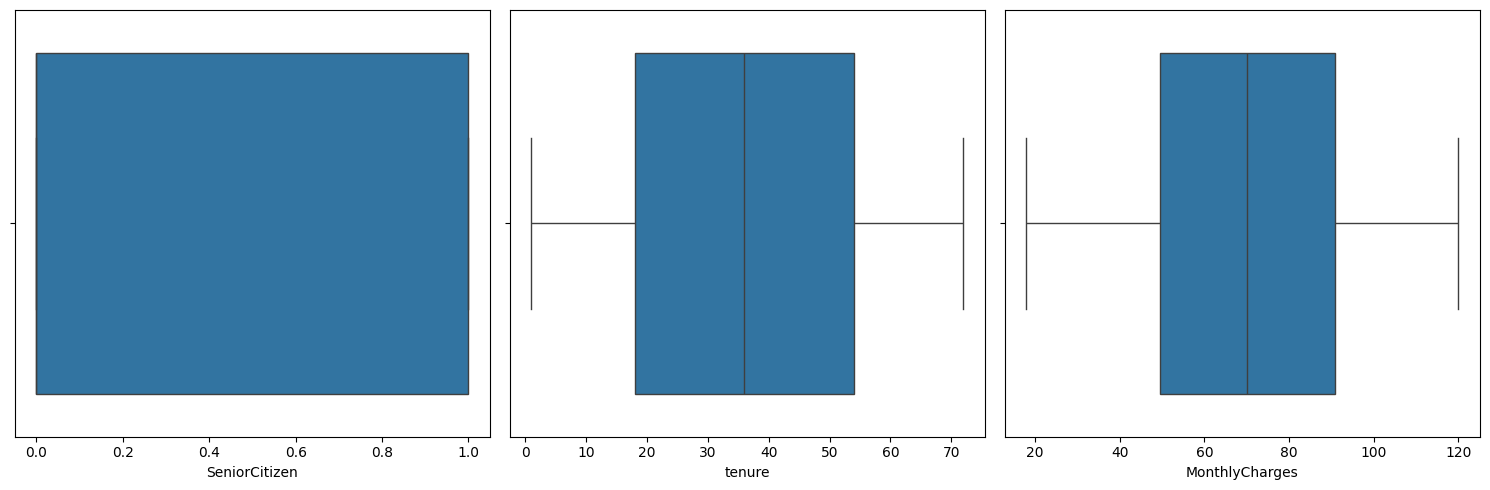

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(numerical_cols):
    sns.boxplot(data=df1, x=column, ax=axes[i])
    
plt.tight_layout()
plt.show()

So, Here no outliers in numerical columns.

### Fix Data Inconsistencies

#### Correcting Inconsistent 'MultipleLines' Values Based on 'PhoneService'

In [20]:
df1['Inconsistent_multiplelines'] = ((df1['PhoneService'] == "No") & (df1['MultipleLines'] == "Yes"))
df1['Inconsistent_multiplelines'].value_counts()

Inconsistent_multiplelines
False    4097
True      834
Name: count, dtype: int64

If a customer does not have **'PhoneService'**, then they cannot have **'MultipleLines'**.

So according to value counts of 'Inconsistent_multiplelines' 845 entries contains wrong data.

In [21]:
# Replace 'Yes' with 'No phone service' where PhoneService is 'No'
df1.loc[(df1['PhoneService'] == 'No') & (df1['MultipleLines'] == 'Yes'), 'MultipleLines'] = 'No phone service'

In [22]:
# drop 'Inconsistent_multiplelines' column 
df1.drop('Inconsistent_multiplelines', axis=1, inplace=True)

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4931 non-null   object 
 1   SeniorCitizen     4931 non-null   int64  
 2   Partner           4931 non-null   object 
 3   Dependents        4931 non-null   object 
 4   tenure            4931 non-null   int64  
 5   PhoneService      4931 non-null   object 
 6   MultipleLines     4931 non-null   object 
 7   InternetService   4931 non-null   object 
 8   OnlineSecurity    4931 non-null   object 
 9   OnlineBackup      4931 non-null   object 
 10  DeviceProtection  4931 non-null   object 
 11  TechSupport       4931 non-null   object 
 12  StreamingTV       4931 non-null   object 
 13  StreamingMovies   4931 non-null   object 
 14  Contract          4931 non-null   object 
 15  PaperlessBilling  4931 non-null   object 
 16  PaymentMethod     4931 non-null   object 
 17  

#### Identifying Invalid 'Yes' Values for Internet-Dependent Services 

In [24]:
# Columns that depend on InternetService
internet_dependent_cols = ['OnlineSecurity', 'OnlineBackup', 'StreamingTV', 'StreamingMovies']

In [25]:
# Count 'Yes' values in those columns where InternetService is 'No' (invalid data)
total_records_to_update = 0
print("Records with invalid 'Yes' values when InternetService is 'No':\n")

for col in internet_dependent_cols:
    invalid_count = df1.loc[(df1['InternetService'] == 'No') & (df1[col] == 'Yes')].shape[0]
    print(f"- {invalid_count} records in column '{col}' need to be updated.")
    total_records_to_update += invalid_count

# Count records where all 4 columns have 'Yes' and InternetService is 'No' (common wrong data)
all_cols_invalid = df1.loc[
    (df1['InternetService'] == 'No') &
    (df1['OnlineSecurity'] == 'Yes') &
    (df1['OnlineBackup'] == 'Yes') &
    (df1['StreamingTV'] == 'Yes') &
    (df1['StreamingMovies'] == 'Yes')
].shape[0]

print(f"\n {all_cols_invalid} records have 'Yes' in **all** internet-dependent columns despite InternetService being 'No'.")
print(f"\n Total individual updates to be made: {total_records_to_update}\n")

Records with invalid 'Yes' values when InternetService is 'No':

- 542 records in column 'OnlineSecurity' need to be updated.
- 529 records in column 'OnlineBackup' need to be updated.
- 533 records in column 'StreamingTV' need to be updated.
- 522 records in column 'StreamingMovies' need to be updated.

 23 records have 'Yes' in **all** internet-dependent columns despite InternetService being 'No'.

 Total individual updates to be made: 2126



####  Replacing Invalid 'Yes' Values with 'No internet service'

In [26]:
# Perform the updates
updated_record_count = 0
for col in internet_dependent_cols:
    mask = (df1['InternetService'] == 'No') & (df1[col] == 'Yes')
    updated_record_count += mask.sum()
    df1.loc[mask, col] = 'No internet service'

print(f"Total records successfully updated: {updated_record_count}")

Total records successfully updated: 2126


## EDA - Exploratory Data Analysis

### Label Encoding on Target Variable for EDA

In [27]:
# label encoding on target variable
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

In [28]:
df1[['Churn']].head()

,Churn
0,0
1,0
2,0
3,1
4,1


### Churn Target Variable Visualization

Churn
0    3622
1    1309
Name: count, dtype: int64

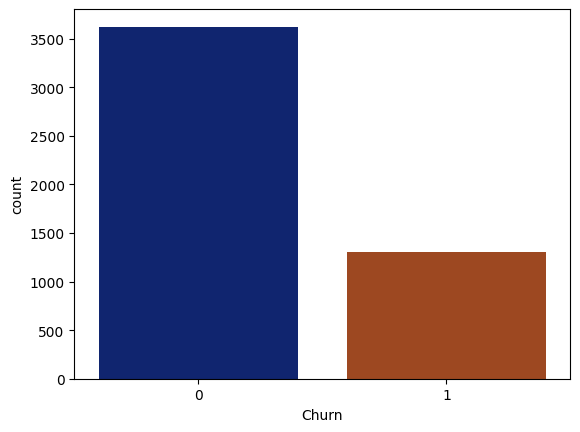

In [29]:
sns.countplot(x='Churn', data=df1, palette='dark')
df1['Churn'].value_counts()

**So, Here data is imbalanced with a ratio of approximately 3:1**

### Categorical Features and Their Impact on the Target Variable (Churn)

In [30]:
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

#### Categorical Features Grouped: Customer Info, Services Signed, and Payment Details

In [31]:
l1 = ['SeniorCitizen','Partner','Dependents'] # Customer Information
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
l3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information

#### Group 1: Customer Information

This group covers simple info about the customer
- SeniorCitizen
- Partner
- Dependents

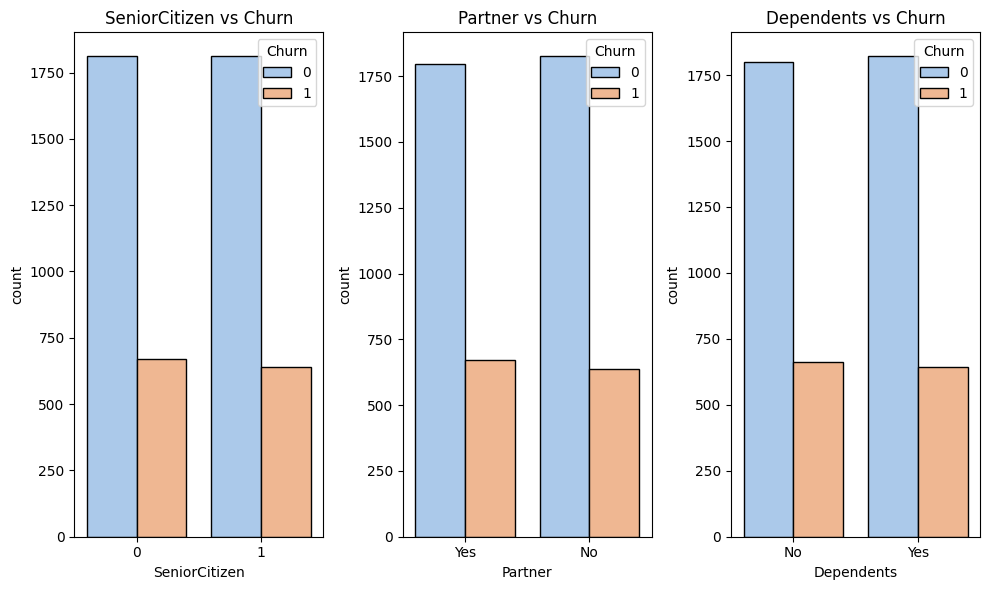

In [32]:
fig = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
for i in range(len(l1)):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=l1[i], data=df1, hue="Churn", palette='pastel', edgecolor='black')
    plt.title(f"{l1[i]} vs Churn")
plt.tight_layout()

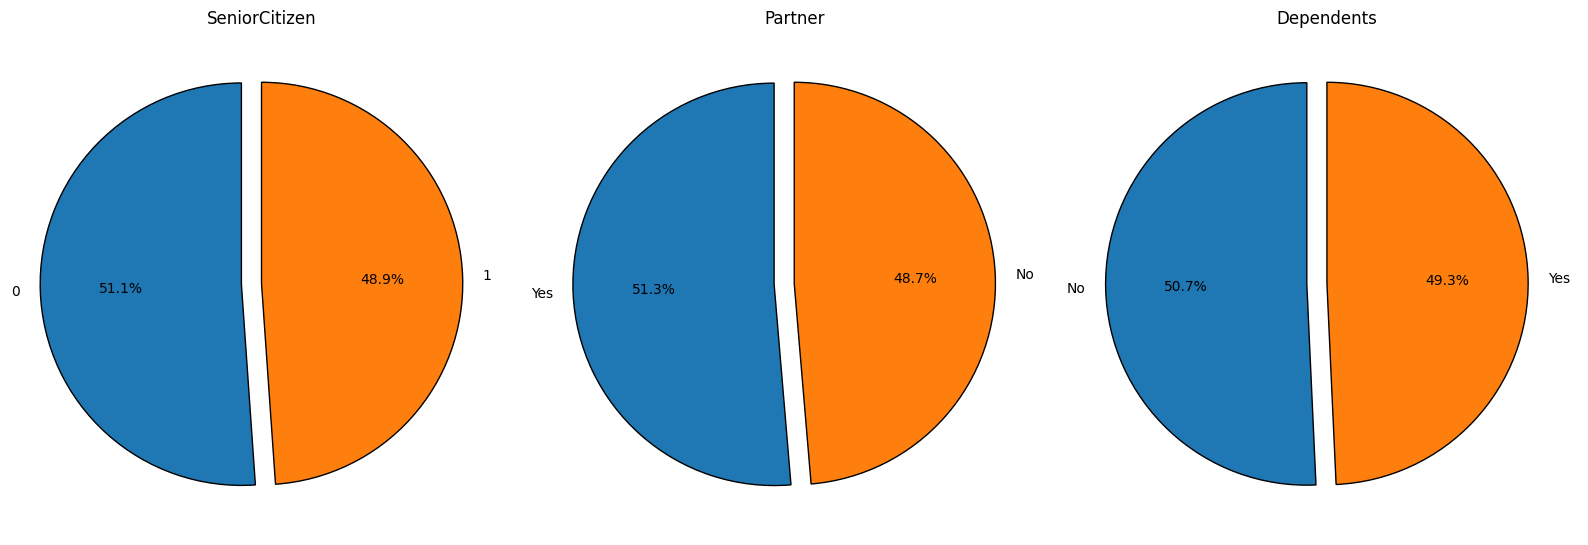

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i, col in enumerate(l1):
    val_counts = df1[df1['Churn'] == 1][col].value_counts(normalize=True) * 100
    labels = val_counts.index.tolist()
    
    axes[i].pie(val_counts, labels=labels, autopct='%1.1f%%',
                startangle=90, explode=[0.1] + [0] * (len(labels) - 1),
                wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


- SeniorCitizen: Non SeniorCitizen have high churn rate than SeniorCitizen.

- Partner Status Impact: Customers with a partner have higher churn rates compared to those without a partner.

- Dependents Influence: Churn rates are higher for customers without dependents, suggesting a potential correlation between familial status and customer retention.

These observations provide insights into specific customer segments that may require targeted retention strategies. Understanding the nuanced behavior within these groups can aid in developing more tailored approaches for customer retention.

#### Group 2: Customer-Enlisted Services

This group covers services subscribed by customer into two groups:

Gorup 1
- PhoneService
- MultipleLines
- InternetService
- StreamingTV
- StreamingMovies

Group 2 - Security & Support Services
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport

#### Group 2.1

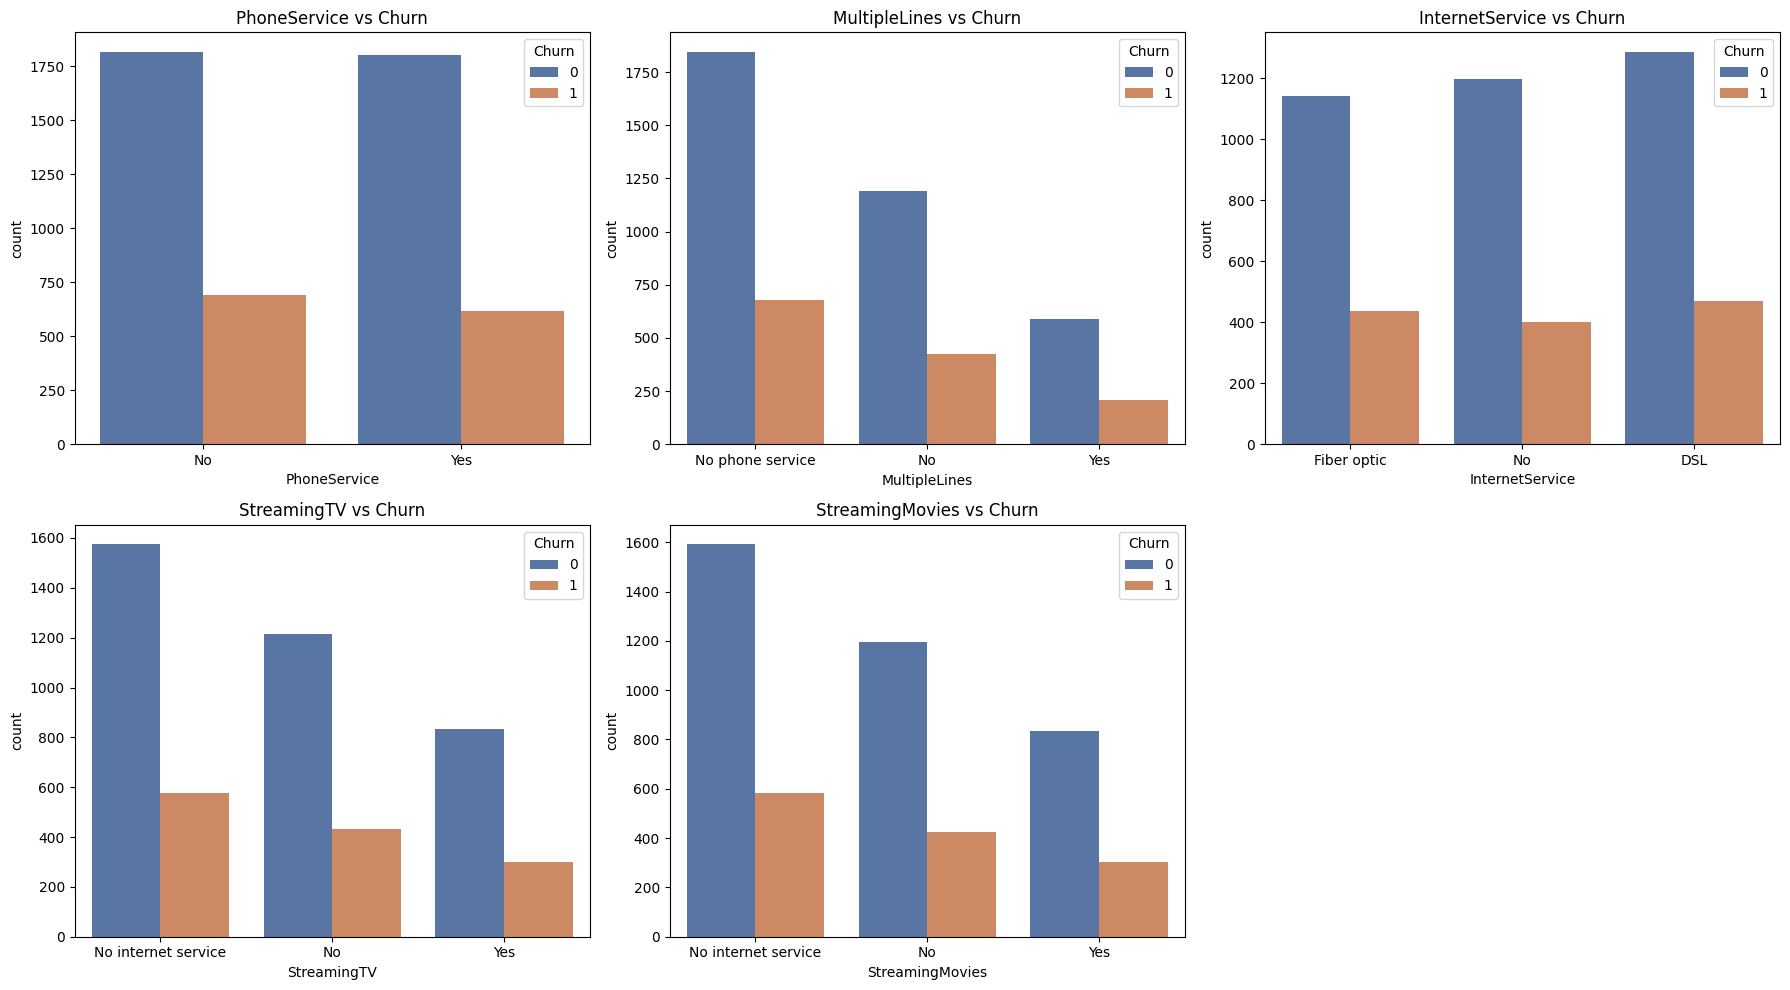

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i in range(5):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.countplot(x=l2[i], data=df1, hue="Churn", palette='deep', ax=ax)
    ax.set_title(f"{l2[i]} vs Churn")

# Hide the 6th (empty) subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


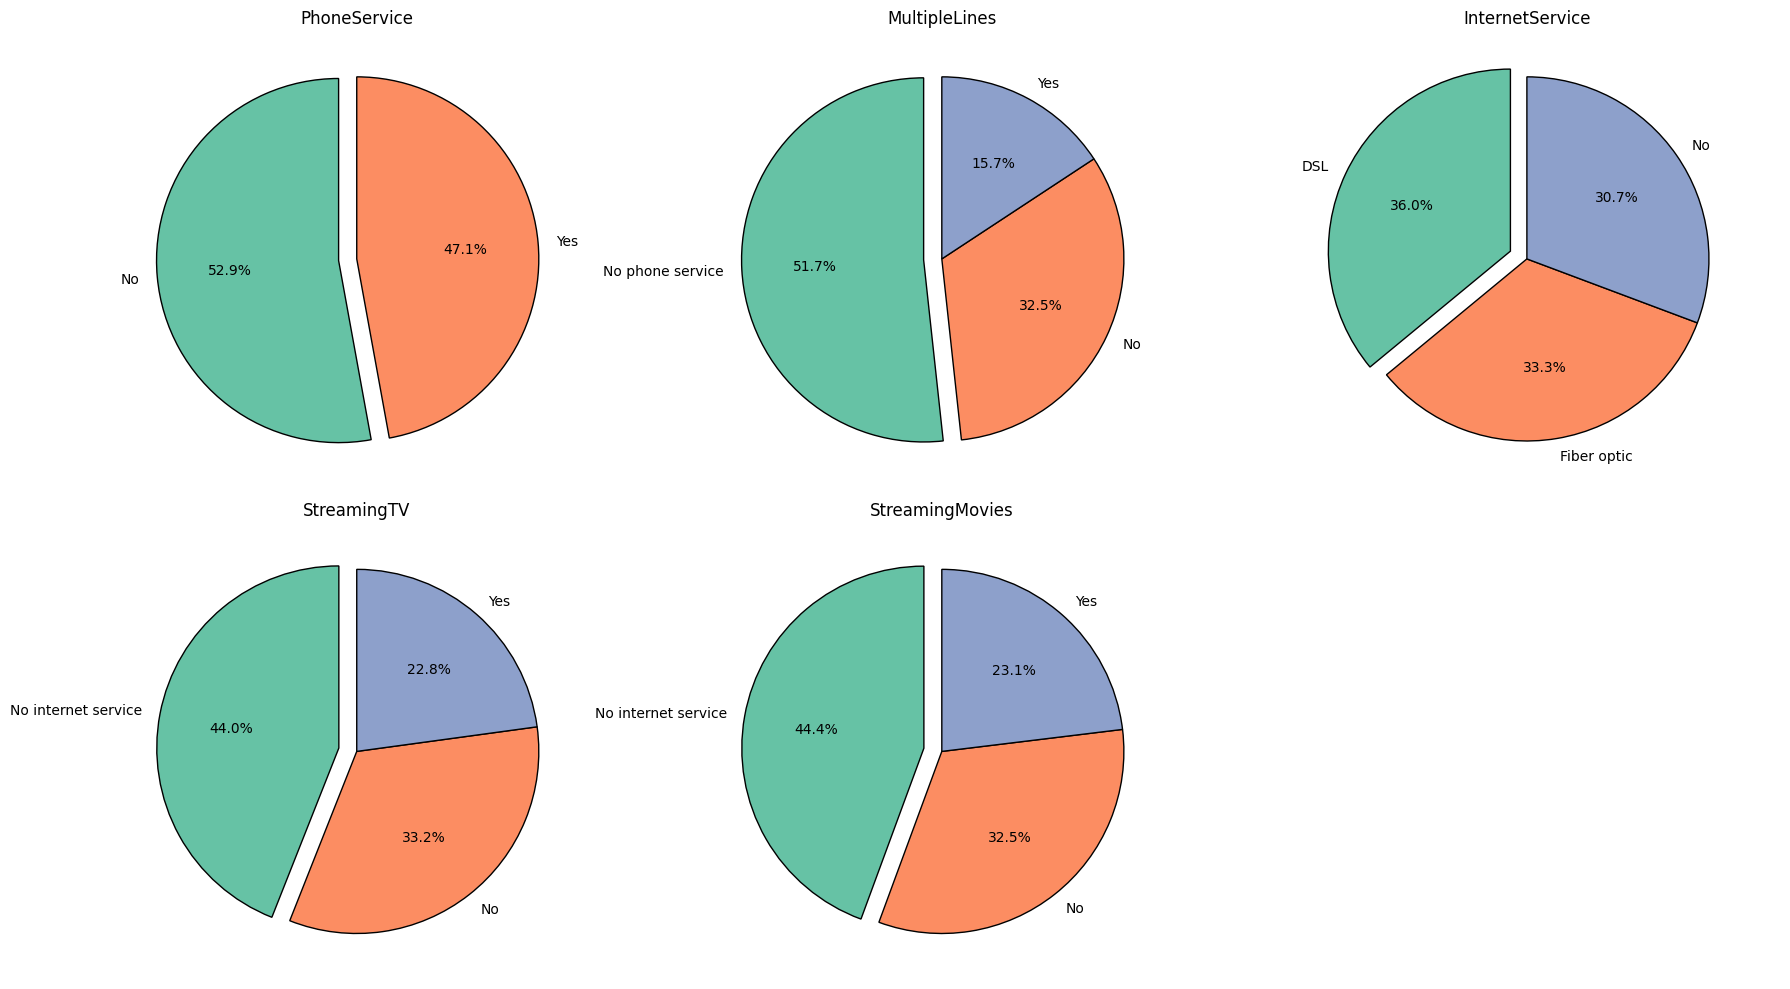

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
colors = sns.color_palette("Set2")

for i, col in enumerate(l2[0:5]):
    row, col_idx = divmod(i, 3)
    ax = axes[row, col_idx]
    
    # Get value counts and labels directly from data
    val_counts = df1[df1['Churn'] == 1][col].value_counts(normalize=True) * 100
    labels = val_counts.index.tolist()

    # Plot pie chart
    ax.pie(val_counts, labels=labels, autopct='%1.1f%%', startangle=90,
           explode=[0.1] + [0] * (len(labels) - 1),
           colors=colors[:len(labels)],
           wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    ax.set_title(col)

# Hide empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


- **PhoneService Analysis:** Customers with no phone service exhibit a slightly higher churn rate compared to those with active phone service, though both groups show substantial retention.

- **MultipleLines Impact:** Churn is more common among customers who have no multiple lines, especially compared to those who opted for multiple lines or have no phone service. This hints that line flexibility may influence retention.

- **InternetService Preferences:** Among the three categories, DSL users churn more frequently, while Fiber Optic and 'No Internet Service' groups show better retention, highlighting potential dissatisfaction with DSL service.

- **StreamingTV & StreamingMovies Behavior:** For both services, customers who do not use streaming or lack internet service still show noticeable churn. Having these services does not clearly prevent churn, indicating streaming access alone doesn’t ensure loyalty.


OR


- **PhoneService:** Churn is nearly split; having phone service doesn’t strongly prevent customer loss.

- **MultipleLines:** Slightly more churn from users without multiple lines; impact is minimal.

- **InternetService:** Churn is evenly spread across types, but DSL has slightly higher churn.

- **StreamingTV/Movies:** High churn among users without internet; streaming services have limited influence on retention.

#### Group 2.2

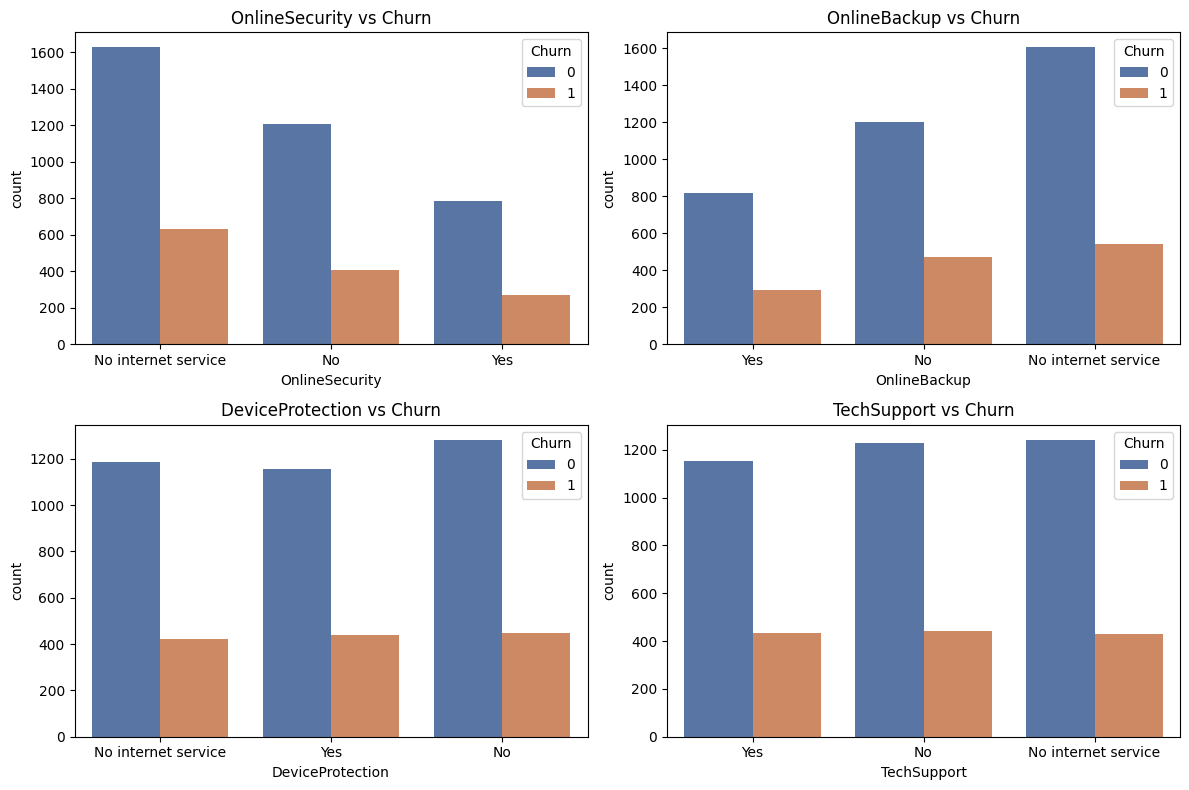

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i in range(4):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.countplot(x=l2[-4 + i], data=df1, hue="Churn", palette='deep', ax=ax)
    ax.set_title(f"{l2[-4 + i]} vs Churn")

plt.tight_layout()
plt.show()

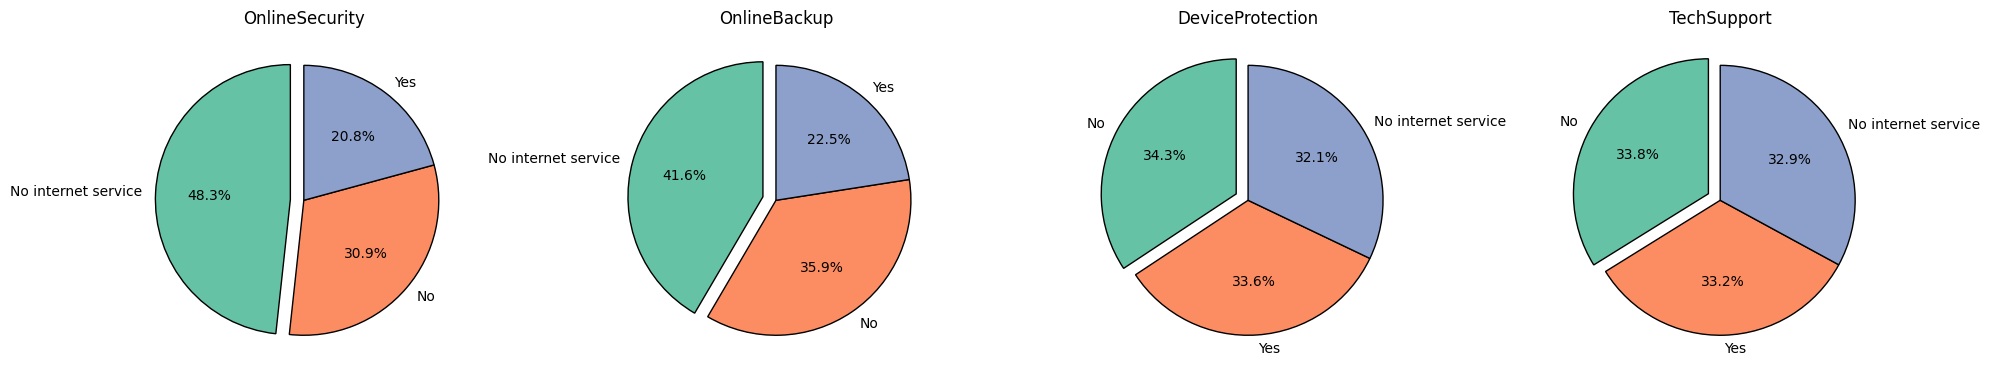

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
colors = sns.color_palette("Set2")

for i, col in enumerate(l2[-4:]):
    ax = axes[i]
    
    val_counts = df1[df1['Churn'] == 1][col].value_counts(normalize=True) * 100
    labels = val_counts.index.tolist()

    ax.pie(val_counts, labels=labels, autopct='%1.1f%%', startangle=90,
           explode=[0.1] + [0] * (len(labels) - 1),
           colors=colors[:len(labels)],
           wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    ax.set_title(col)

plt.tight_layout()
plt.show()


- OnlineSecurity: Customers without OnlineSecurity (or no internet service) churn more. Security services seem to help reduce churn.

- OnlineBackup: People without backup are leaving more. Those with backups show better retention, suggesting backup services matter.

- DeviceProtection: Having no protection plan correlates with higher churn. Customers with protection are less likely to leave.

- TechSupport: No TechSupport? More likely to churn. Providing support appears to keep customers around longer.

Customers who subscribe to support and protection services — like security, backups, and tech support — are less likely to churn. These services play a key role in improving satisfaction and trust, which helps retain customers more effectively.


OR

- **OnlineSecurity & OnlineBackup:** A large share of churned customers had no internet service, limiting their access to these features. Among those with access, many did not subscribe — indicating low adoption and possible lack of perceived value.

- **DeviceProtection & TechSupport:** Churn is evenly distributed across users with or without these services. This suggests that offering these alone may not be enough to retain customers without addressing other core service factors.

#### Group 3: Payment & Billing Information

This group encompasses features related to contractual terms, billing preferences, and payment methods

- Contract
- PaperlessBilling
- PaymentMethod

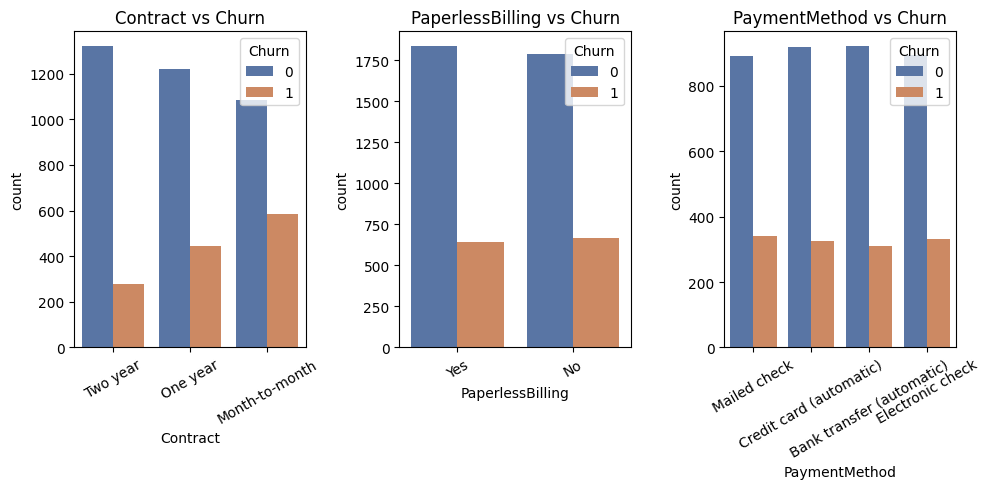

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i in range(3):
    ax = axes[i]
    sns.countplot(x=l3[i], data=df1, hue="Churn", palette='deep', ax=ax)
    ax.set_title(f"{l3[i]} vs Churn")
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

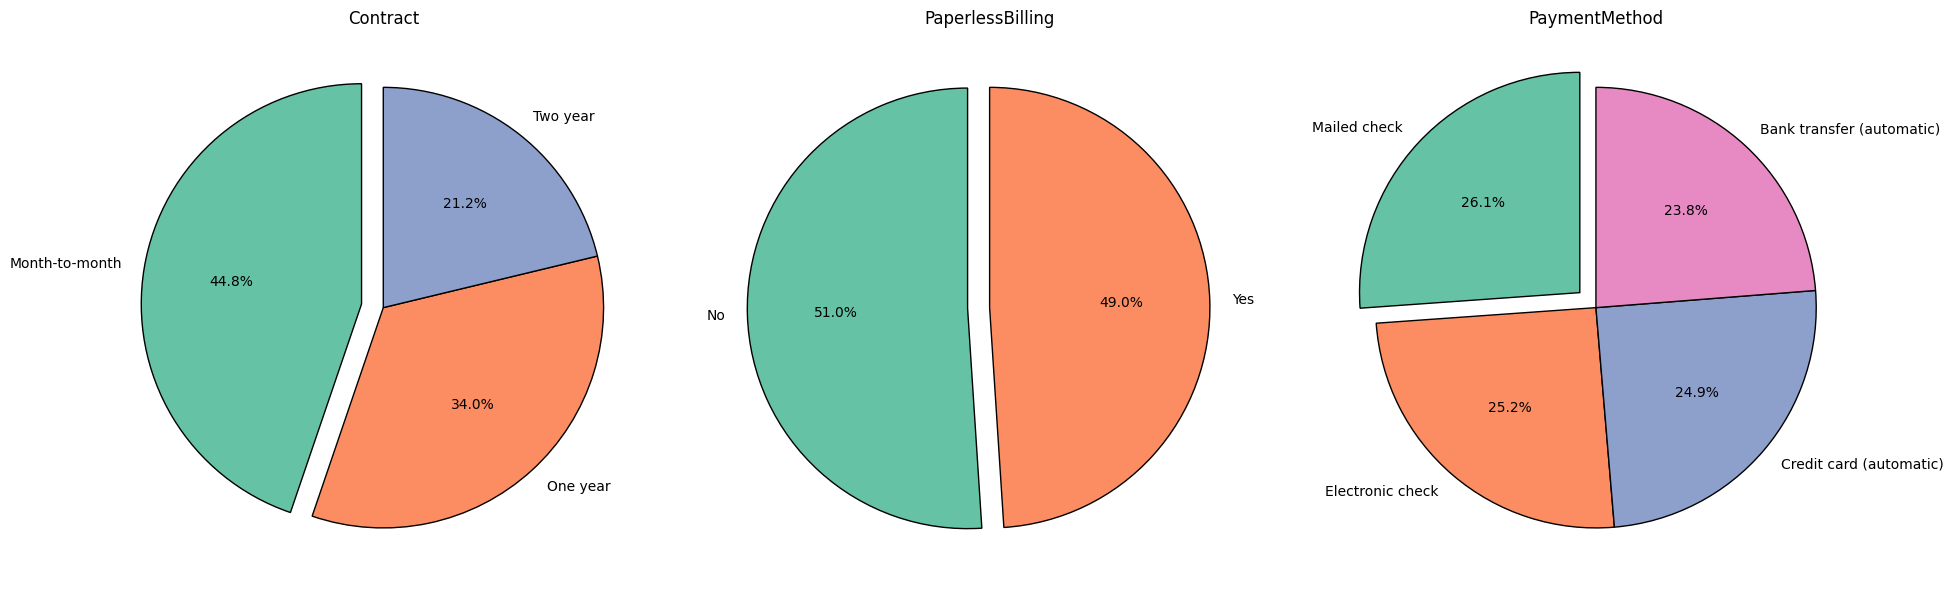

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
colors = sns.color_palette("Set2")

for i, col in enumerate(l3):
    ax = axes[i]
    
    val_counts = df1[df1['Churn'] == 1][col].value_counts(normalize=True) * 100
    labels = val_counts.index.tolist()

    ax.pie(val_counts, labels=labels, autopct='%1.1f%%', startangle=90,
           explode=[0.1] + [0] * (len(labels) - 1),
           colors=colors[:len(labels)],
           wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    ax.set_title(col)

plt.tight_layout()
plt.show()


- **Contract Analysis:** Customers with Month-to-Month contracts show the highest churn, while those with One or Two-year contracts churn far less. This suggests that short-term contracts may indicate uncertainty or low commitment.

- **PaperlessBilling Impact:** Churn levels are similar across both PaperlessBilling options, indicating that billing format alone may not strongly influence churn — but could still interact with other factors like payment method or digital engagement.

- **PaymentMethod Insights:** Churn appears relatively consistent across all payment methods, with no dramatic spike in any single method. However, Mailed Check shows slightly more churn than others, which may warrant further investigation.

- **Overall Insight:** Contract length clearly plays a major role in churn behavior — longer-term contracts help retain customers. While billing type and payment method show less distinct patterns, understanding their interactions with other features may provide additional churn prevention strategies.

OR

- **Contract Duration Impact:** Churn is highest among Month-to-Month customers (44.8%), while Two-year contracts account for the least churn (21.2%), suggesting that longer commitments help reduce churn.

- **PaperlessBilling Analysis:** Churn is nearly balanced between users who opted in and out of PaperlessBilling, indicating no strong influence of billing mode on customer retention.

- **PaymentMethod Insights:** Churn is evenly distributed across all payment methods, with no method showing a dominant issue. This suggests payment method choice alone isn’t a major driver of churn in this dataset.

### Numerical Features and Their Impact on the Target Variable (Churn)

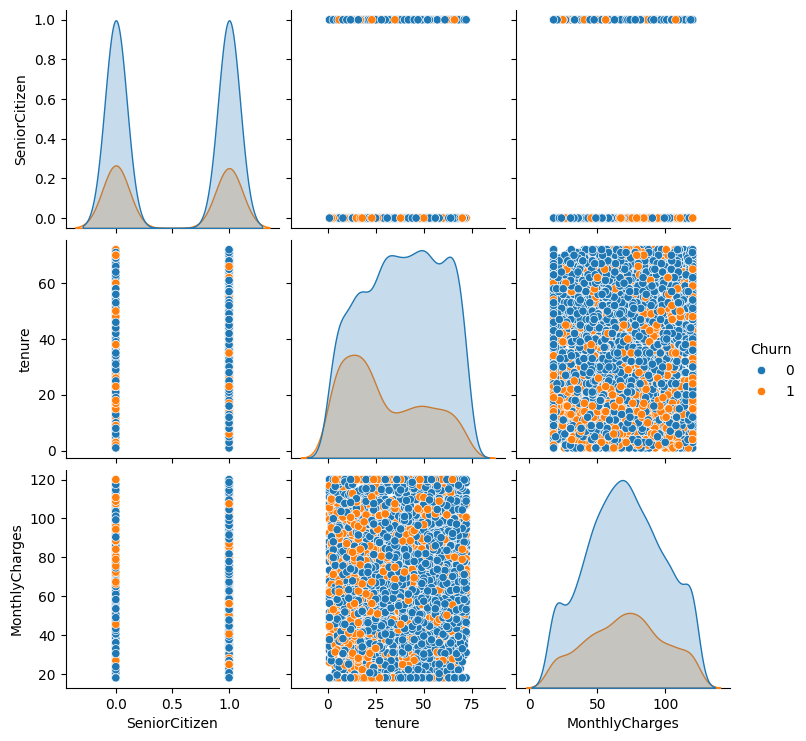

In [40]:
sns.pairplot(df1, vars=numerical_cols[:3], hue='Churn')

- Customers with lower tenure (less than 30 months) or New customers are more likely to churn.
- Customers with higher monthly charges are more likely to churn

#### MonthlyCharges vs Contract Type with Churn

Text(0.5, 1.0, 'Monthly Charges by Contract Type and Churn Status')

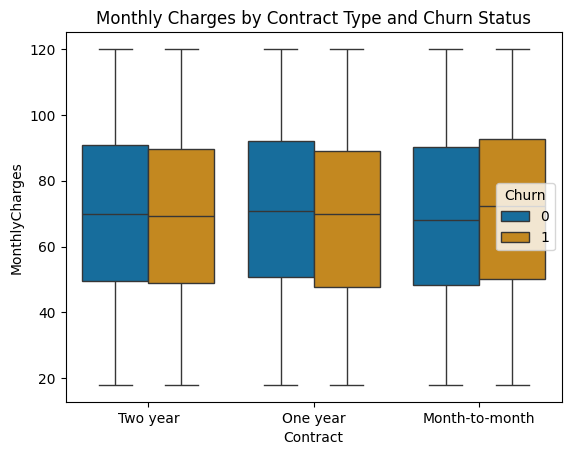

In [41]:
sns.boxplot(data=df1, x='Contract', y='MonthlyCharges', hue='Churn', palette="colorblind")
plt.title("Monthly Charges by Contract Type and Churn Status")

- Month-to-month contracts have higher monthly charges and higher churn rates than longer contracts.

#### Churn Rate by Dependent Status and Partrner

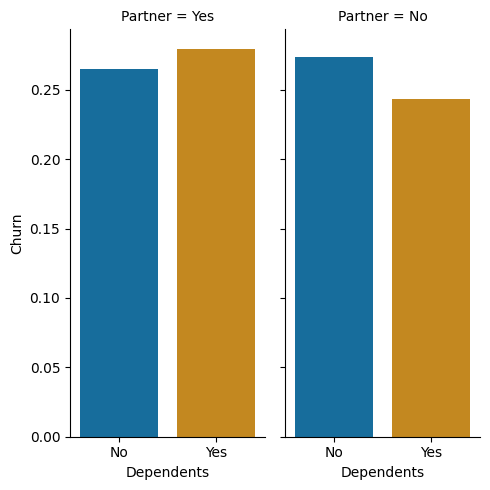

In [42]:
sns.catplot(data=df1, x='Dependents', y='Churn', col='Partner', kind='bar', ci=None, palette="colorblind", aspect=.5)

- When customer has both dependents and Partner then Churn rate is high and When customer has Dependents but no partner have low Churn rate.

### Categorical Features and Their Impact on the Target Variable (MonthlyCharges)

#### Monthly Charges by Service Group

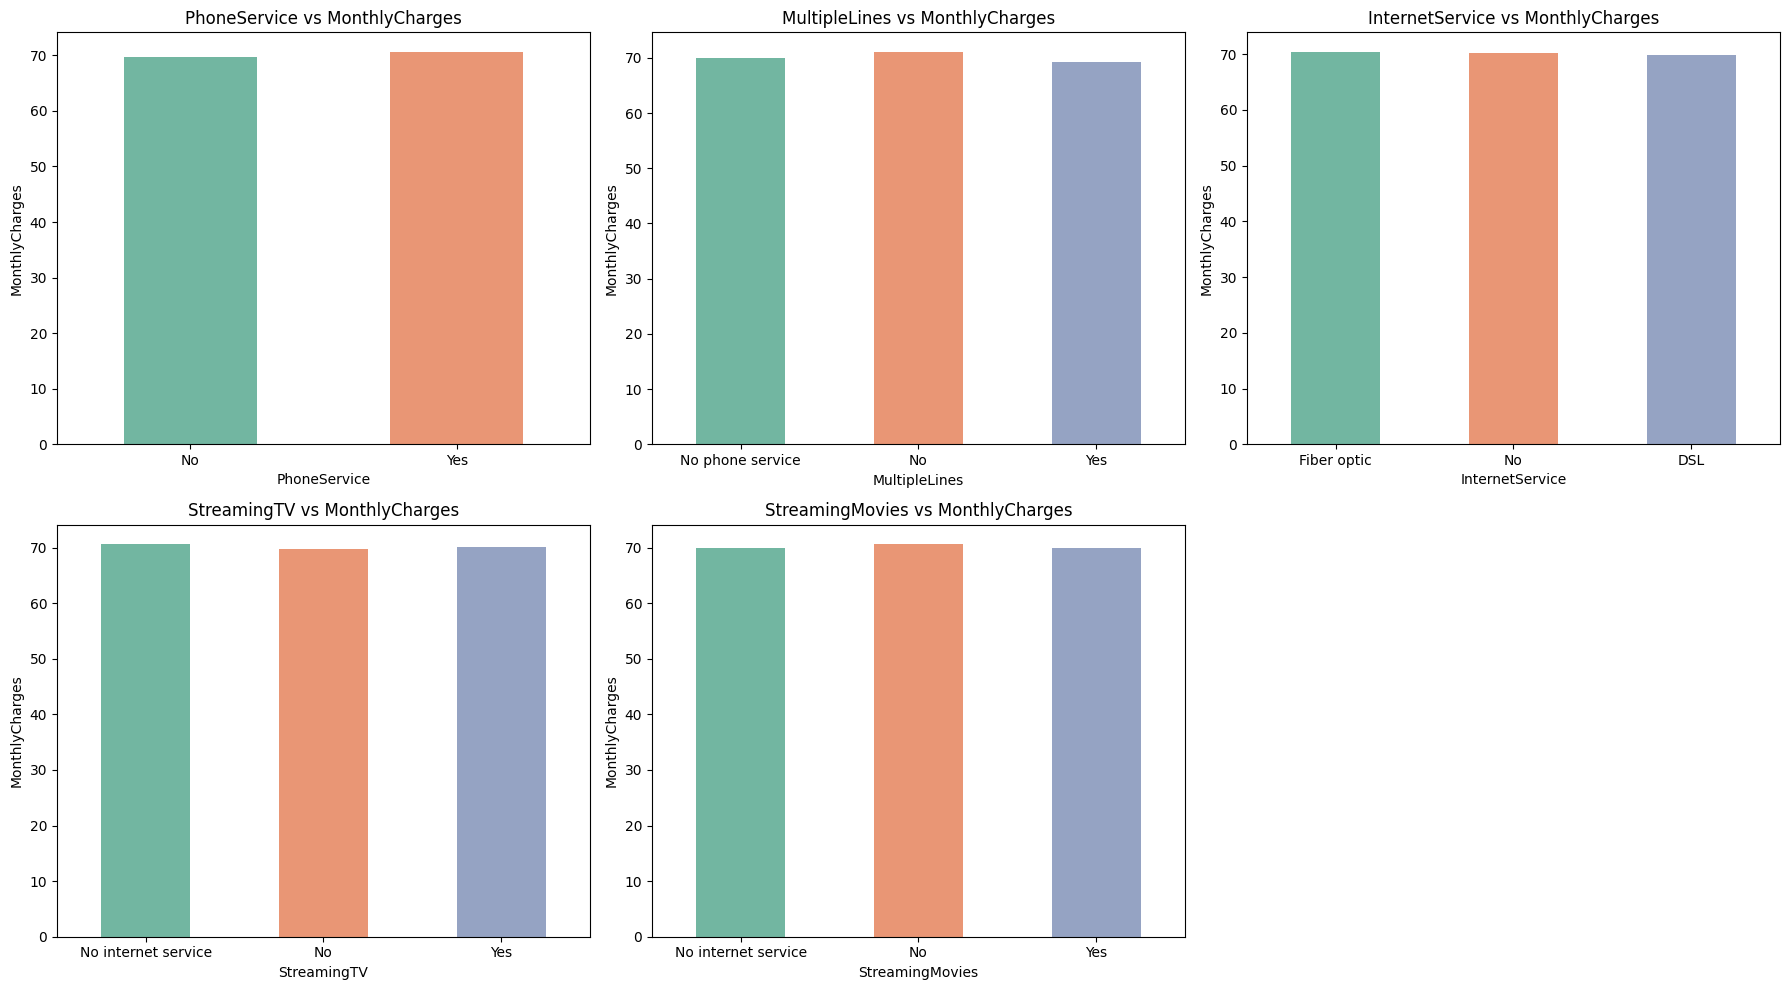

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i, col in enumerate(l2[0:5]):
    row, coln = divmod(i, 3)
    sns.barplot(x=col, y="MonthlyCharges", data=df1, palette="Set2", ax=axes[row, coln], ci=None, width=0.5)
    axes[row, coln].set_title(f"{col} vs MonthlyCharges")

axes[1, 2].axis('off')  # Hide the empty subplot
plt.tight_layout()
plt.show()

- All five services — PhoneService, MultipleLines, InternetService, StreamingTV, and StreamingMovies — show minimal impact on average MonthlyCharges, with values staying almost the same across categories.

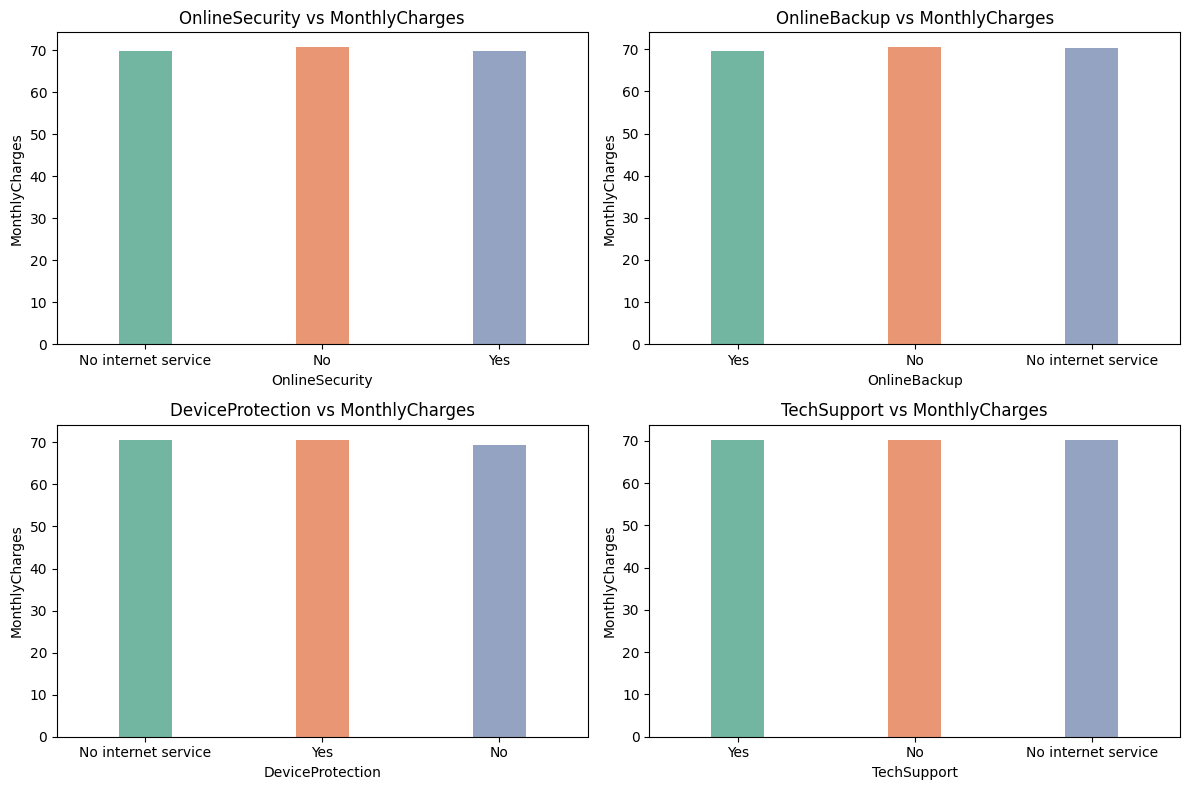

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, col in enumerate(l2[5:9]):
    row, coln = divmod(i, 2)
    sns.barplot(x=col, y="MonthlyCharges", data=df1, palette="Set2", ax=axes[row, coln], ci=None, width=0.3)
    axes[row, coln].set_title(f"{col} vs MonthlyCharges")

plt.tight_layout()
plt.show()

- OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport all show negligible impact on MonthlyCharges — average charges remain almost the same across all service categories.

#### Contract, PaperlessBilling and PaymentMethod vs MonthlyCharges

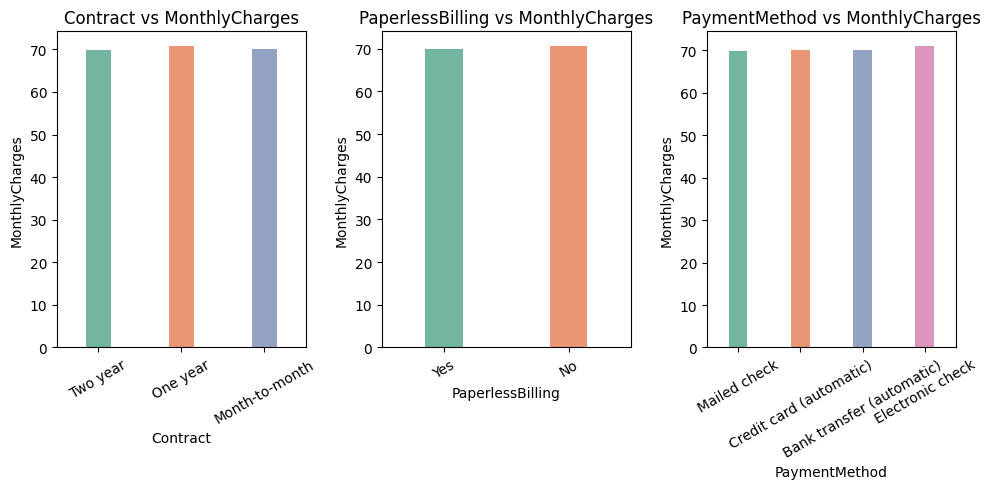

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, col in enumerate(l3[0:4]):
    sns.barplot(x=col, y="MonthlyCharges", data=df1, palette="Set2", ax=axes[i], ci=None, width=0.3)
    axes[i].set_title(f"{col} vs MonthlyCharges")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

- Contract – Monthly charges are nearly the same across contract types.

- PaperlessBilling – No difference in charges between Yes and No.

- PaymentMethod – Charges stay consistent across payment methods.

#### StreamingTV, StreamingMovies vs MonthlyCharges

<Axes: xlabel='StreamingMovies', ylabel='StreamingTV'>

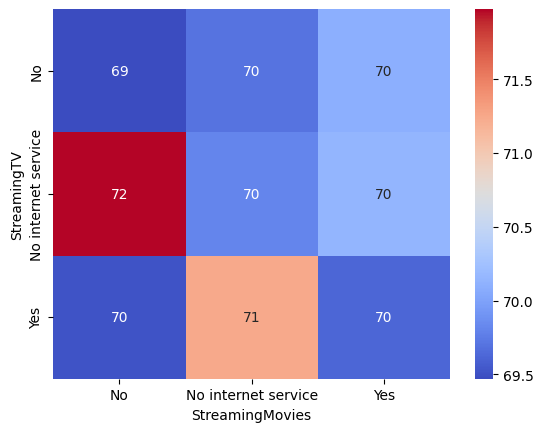

In [46]:
pivot = df1.pivot_table(values='MonthlyCharges', index='StreamingTV', columns='StreamingMovies')
sns.heatmap(pivot, annot=True, cmap='coolwarm')

- Customers without internet service have slightly higher charges.
- StreamingTV + StreamingMovies does not raise charges much.

#### MonthlyCharges vs Dependents and Partner with Churn

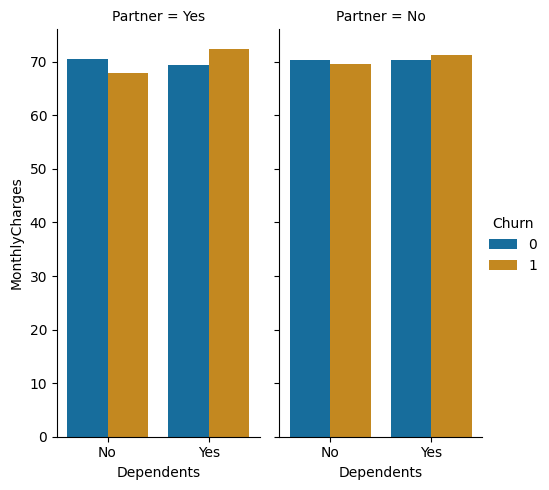

In [47]:
sns.catplot(data=df1, x='Dependents', y='MonthlyCharges', col='Partner', hue='Churn', kind='bar', ci=None, palette="colorblind", aspect=.5)

- Customers without dependents and a partner tend to have higher monthly charges and are more likely to churn.

### Numerical Features and Their Impact on the Target Variable (MonthlyCharges)

#### Tenure vs MonthlyCharges

In [ ]:
# reamining

#### Seniorcitizen vs MonthlyCharges

#### Partner vs MonthlyCharges

## Encoding

In [ ]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Male,0,Yes,No,54,No,No phone service,Fiber optic,No internet service,Yes,No internet service,Yes,No internet service,No internet service,Two year,Yes,Mailed check,96.48,0
1,Female,0,No,No,35,Yes,No,No,No internet service,No,Yes,Yes,No,No internet service,One year,No,Credit card (automatic),87.58,0
2,Male,0,Yes,No,36,Yes,No phone service,No,No internet service,No internet service,No internet service,Yes,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),79.78,0
3,Male,0,No,Yes,13,No,No phone service,Fiber optic,No,Yes,No,No,No internet service,No internet service,One year,Yes,Bank transfer (automatic),112.28,1
4,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No internet service,No internet service,Month-to-month,Yes,Mailed check,45.77,1


In [ ]:
numerical_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges']

In [ ]:
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Ordinal Encoding

#### Ordinal encoding on 'Contract' as it contains ordered values

In [ ]:
contract_order = [['Month-to-month', 'One year', 'Two year']]
ord_encoder = OrdinalEncoder(categories=contract_order)
df1[['Contract']] = ord_encoder.fit_transform(df1[['Contract']])

### Label Encoding

#### Label Encoding on 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'PaymentMethod' (Contain yes/no values & male/female)

In [ ]:
# Columns to encode
label_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'PaymentMethod']

# Apply LabelEncoder to each column
le = LabelEncoder()
for col in label_cols:
    df1[col] = le.fit_transform(df1[col])

#### Label Encoding on InternetService dependent columns where values are: 'Yes', 'No', 'No internet service' / 'No phone service'

In [ ]:
# InternetService dependent columns where values are: 'Yes', 'No', 'No internet service' / 'No phone service'
internet_dependent_cols = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# label encoding
for col in internet_dependent_cols:
    encoder = LabelEncoder()
    df1[col] = encoder.fit_transform(df1[col])

### One-hot Encoding

#### One-hot Encoding on 'InternetService'

In [ ]:
internet_encoder = OneHotEncoder(drop=None, sparse_output=False, dtype=int)
internet_encoded = internet_encoder.fit_transform(df1[['InternetService']])
internet_encoded_cols = internet_encoder.get_feature_names_out(['InternetService'])
df1[internet_encoded_cols] = internet_encoded
# Drop the original 'InternetService' column
df1.drop('InternetService', axis=1, inplace=True)

In [ ]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,1,0,1,0,54,0,1,1,2,1,...,1,1,2.0,1,3,96.48,0,0,1,0
1,0,0,0,0,35,1,0,1,0,2,...,0,1,1.0,0,1,87.58,0,0,0,1
2,1,0,1,0,36,1,1,1,1,1,...,1,1,0.0,0,0,79.78,0,0,0,1
3,1,0,0,1,13,0,1,0,2,0,...,1,1,1.0,1,0,112.28,1,0,1,0
4,1,1,0,1,26,1,0,0,2,0,...,1,1,0.0,1,3,45.77,1,0,1,0


In [ ]:
df1.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No
count,4931.000000,4931.000000,4931.00000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,...,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000
mean,0.500913,0.497059,0.50071,0.500101,36.329751,0.491178,0.833097,0.888055,0.886433,0.972419,...,0.895964,0.901237,0.985398,0.501724,1.498479,70.190146,0.265463,0.356317,0.319611,0.324072
std,0.500050,0.500042,0.50005,0.500051,20.705399,0.499973,0.678807,0.727357,0.742563,0.820904,...,0.743822,0.741538,0.813794,0.500048,1.117693,27.911105,0.441624,0.478959,0.466373,0.468075
min,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,49.425000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.00000,1.000000,36.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,70.050000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.00000,1.000000,54.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,90.900000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,1.000000,3.000000,120.000000,1.000000,1.000000,1.000000,1.000000


## Correlation & Heatmap

### Heatmap Comparison of Churned vs Not Churned Customers (Mean Feature Distribution)


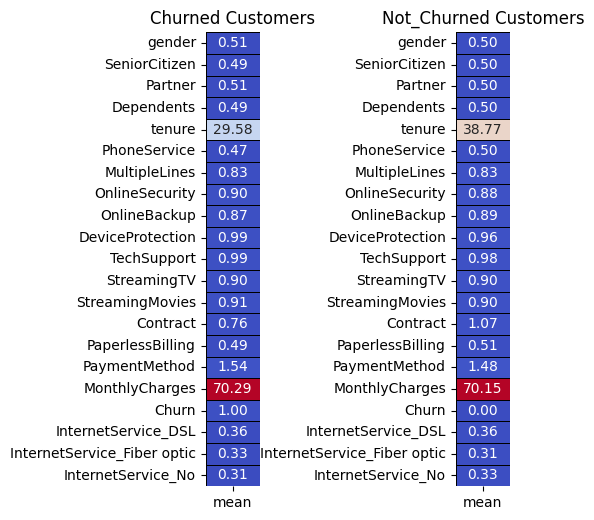

In [ ]:
churn = df1[df1['Churn'] == 1].describe().T
not_churn = df1[df1['Churn'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(churn[['mean']],annot = True,cmap = 'coolwarm',linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Churned Customers')

plt.subplot(1,2,2)
sns.heatmap(not_churn[['mean']],annot = True,cmap = 'coolwarm',linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Not_Churned Customers')

fig.tight_layout(pad = 0)

- Mean Tenure: Customers who churned had a lower mean tenure (29.58 months) compared to those who continued (38.77 months).

- Online Services: Features like OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport have higher mean values for Churned customers.

- Contract Duration: Churned customer contracts are notably shorter than those of not-churned customers.

- Monthly Charges: Mean MonthlyCharges for churned customers (70.29) are slightly higher than for not-churned customers (70.15).

These insights highlight areas for potential focus in retaining customers and emphasize the importance of specific features in influencing customer churn. 

### Correalation Heatmap of all features

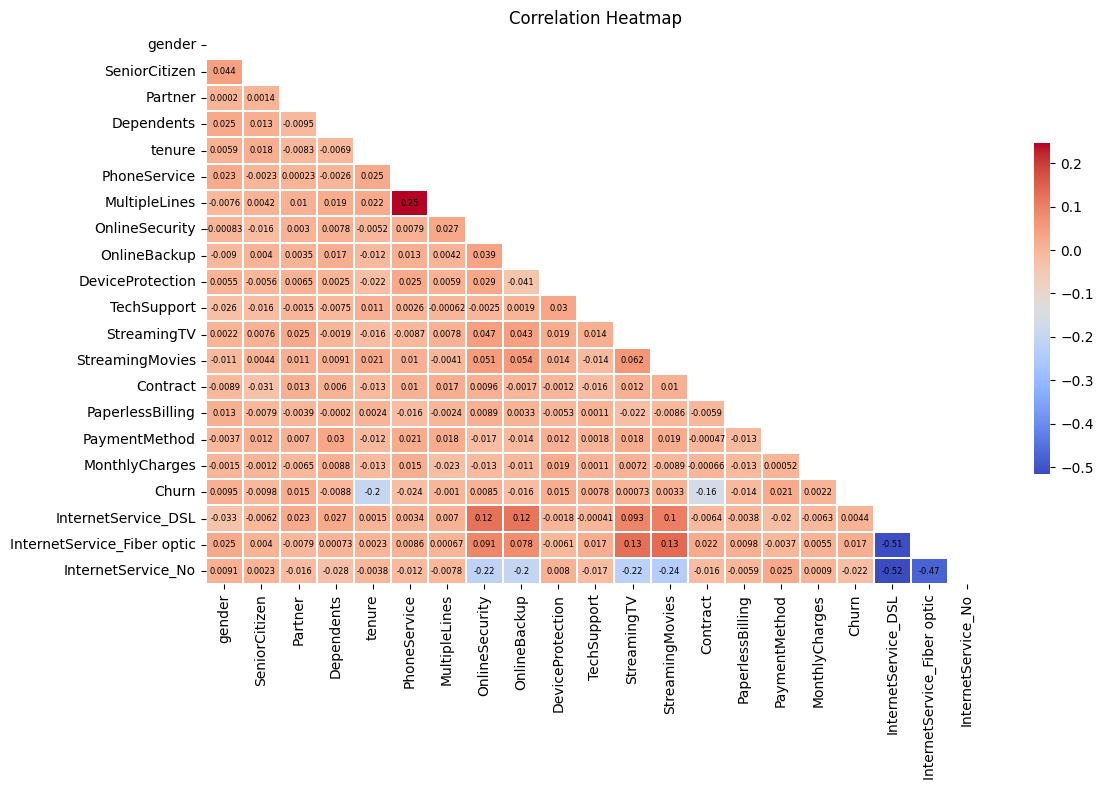

In [ ]:
corr = df1.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
plt.title("Correlation Heatmap")
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, linewidths=1.3, cbar_kws={"shrink": 0.6}, annot_kws={"size": 6, "color": 'black'})
plt.tight_layout()
plt.show()

##### Observations (from Heatmap)
- tenure has a strong negative correlation with Churn (≈ -0.21) → longer staying customers churn less.
- Contract type also shows strong negative correlation with Churn (≈ -0.17) → longer contracts = reduced churn.
- InternetService_Fiber optic has a strong positive correlation with Churn (+0.52) → fiber users are more likely to churn.
- InternetService_No has a strong negative correlation with Churn (-0.47) → customers with no internet churn less (likely inactive accounts).
- OnlineSecurity, TechSupport, and StreamingTV have weak negative correlation with Churn (~ -0.2 to -0.25) → suggest churn protection.
- MonthlyCharges has very low correlation with Churn (~0.02) → cost alone doesn't strongly affect churn.
- Features like Partner, gender, and PaymentMethod have near-zero correlation → likely not useful individually.
- MultipleLines has a positive correlation with Churn (+0.25) → customers with multiple lines may churn more.

### Correlation plot of all features vs Churn

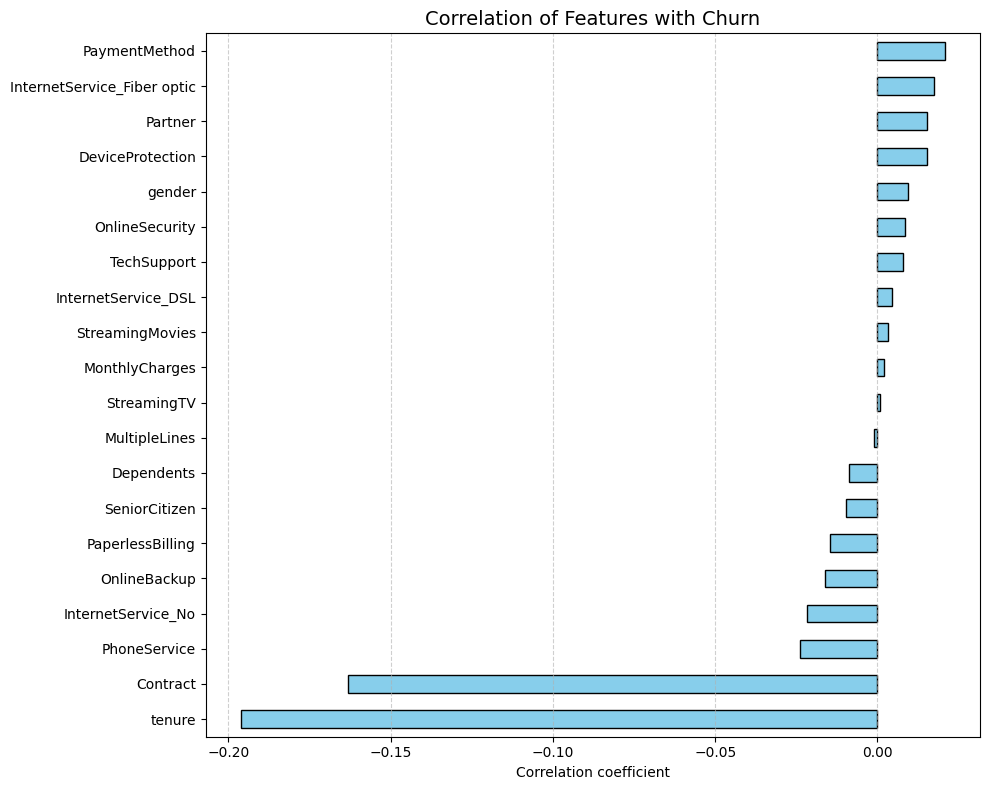

In [ ]:
# Compute correlation of all features with 'Churn'
churn_corr = df1.corr()['Churn'].drop('Churn')  # exclude self-correlation

# Plot as bar chart
plt.figure(figsize=(10, 8))
churn_corr.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Correlation of Features with Churn", fontsize=14)
plt.xlabel("Correlation coefficient")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


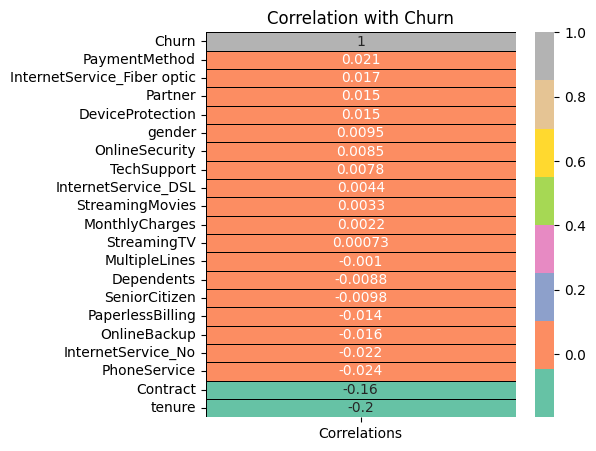

In [ ]:
# Calculate correlation matrix
corr = df1.corr()['Churn'].sort_values(ascending=False).to_frame()
corr.columns = ['Correlations']

# Plot heatmap
plt.subplots(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap=colors, linewidths=0.4, linecolor='black')
plt.title('Correlation with Churn')
plt.show()

##### Observations from Churn Correlation Plot
- Tenure has the strongest negative correlation (≈ -0.22) — longer customers stay, less likely they churn.
- Contract type also negatively correlates — longer contracts = lower churn.
- PhoneService shows slight churn resistance — users with phone service churn a bit less.
- OnlineBackup, TechSupport, and DeviceProtection show weak negative correlation — slight churn protection.
- PaymentMethod has a small positive correlation — certain payment types may relate to higher churn.
- Most features have very low correlation (near 0), implying minimal linear impact individually.

### Correlation plot of all features vs MonthlyCharges

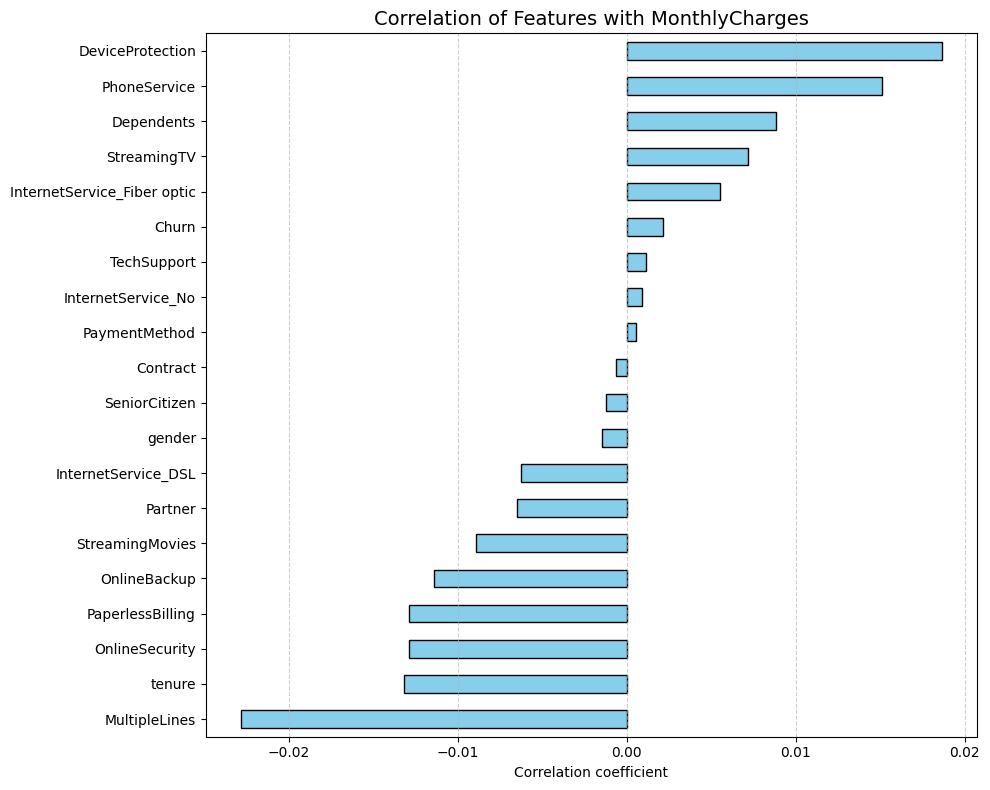

In [ ]:
# Compute correlation of all features with 'MonthlyCharges'
monthlycharge_corr = df1.corr()['MonthlyCharges'].drop('MonthlyCharges')  # exclude self-correlation

# Plot as bar chart
plt.figure(figsize=(10, 8))
monthlycharge_corr.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Correlation of Features with MonthlyCharges", fontsize=14)
plt.xlabel("Correlation coefficient")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


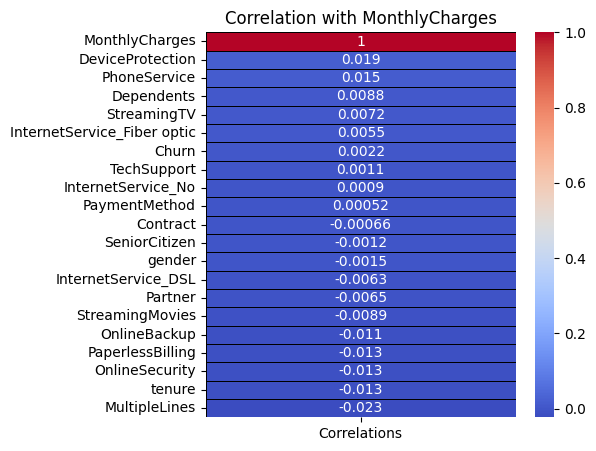

In [ ]:
# Calculate correlation matrix
corr = df1.corr()['MonthlyCharges'].sort_values(ascending=False).to_frame()
corr.columns = ['Correlations']

# Plot heatmap
plt.subplots(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black')
plt.title('Correlation with MonthlyCharges')
plt.show()

##### Observations from MonthlyCharges Correlation Plot
- Customers with DeviceProtection, PhoneService, and StreamingTV tend to pay higher monthly charges.
- Users with Fiber optic internet pay more — confirms it's a premium service.
- Customers with no internet service have lower charges, as expected.
- MultipleLines has a slight negative correlation — possibly due to bundled discounts lowering average cost.

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       4931 non-null   int64  
 1   SeniorCitizen                4931 non-null   int64  
 2   Partner                      4931 non-null   int64  
 3   Dependents                   4931 non-null   int64  
 4   tenure                       4931 non-null   int64  
 5   PhoneService                 4931 non-null   int64  
 6   MultipleLines                4931 non-null   int64  
 7   OnlineSecurity               4931 non-null   int64  
 8   OnlineBackup                 4931 non-null   int64  
 9   DeviceProtection             4931 non-null   int64  
 10  TechSupport                  4931 non-null   int64  
 11  StreamingTV                  4931 non-null   int64  
 12  StreamingMovies              4931 non-null   int64  
 13  Contract               

### Dropping unncessary columns

In [ ]:
unnecessary_cols = ['Partner', 'gender']
df1.drop(columns=unnecessary_cols, axis=1, inplace=True)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SeniorCitizen                4931 non-null   int64  
 1   Dependents                   4931 non-null   int64  
 2   tenure                       4931 non-null   int64  
 3   PhoneService                 4931 non-null   int64  
 4   MultipleLines                4931 non-null   int64  
 5   OnlineSecurity               4931 non-null   int64  
 6   OnlineBackup                 4931 non-null   int64  
 7   DeviceProtection             4931 non-null   int64  
 8   TechSupport                  4931 non-null   int64  
 9   StreamingTV                  4931 non-null   int64  
 10  StreamingMovies              4931 non-null   int64  
 11  Contract                     4931 non-null   float64
 12  PaperlessBilling             4931 non-null   int64  
 13  PaymentMethod          

## Train-Test-Split

In [ ]:
df1['Churn'].value_counts(normalize=True) * 100

Churn
0    73.453661
1    26.546339
Name: proportion, dtype: float64

**So, data is imbalanced**

### Train-Test-Split for Regression and Classification models

#### Regression

In [ ]:
# Separating features and target for Regression
X_reg = df1.drop('MonthlyCharges', axis=1)
y_reg = df1['MonthlyCharges']

# train, test, split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

#### Classification

In [ ]:
# Separating features and target for classification
X_cls = df1.drop('Churn', axis=1)
y_cls = df1['Churn']

# train, test, split for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

## Handling Imbalanced data

### Handling Imbalance data using SMOTE for classification models

In [ ]:
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_resampled_cls, y_resampled_cls = smote.fit_resample(X_train_cls, y_train_cls)

In [ ]:
# Verify class balance
print(y_resampled_cls.value_counts(normalize=True) * 100)

Churn
0    62.502697
1    37.497303
Name: proportion, dtype: float64


## Feature Selection

## Scaling

In [ ]:
df1.head().T

,0,1,2,3,4
SeniorCitizen,0.00,0.00,0.00,0.00,1.00
Dependents,0.00,0.00,0.00,1.00,1.00
tenure,54.00,35.00,36.00,13.00,26.00
PhoneService,0.00,1.00,1.00,0.00,1.00
MultipleLines,1.00,0.00,1.00,1.00,0.00
OnlineSecurity,1.00,1.00,1.00,0.00,0.00
OnlineBackup,2.00,0.00,1.00,2.00,2.00
DeviceProtection,1.00,2.00,1.00,0.00,0.00
TechSupport,2.00,2.00,2.00,0.00,0.00
StreamingTV,1.00,0.00,1.00,1.00,1.00


#### Scaling for regression data

In [ ]:
# Features to scale
reg_scale_cols = ['tenure']

scaler_reg = StandardScaler()
# Fit-transform on train, transform on test
X_train_reg_scaled = X_train_reg.copy()
X_test_reg_scaled = X_test_reg.copy()

X_train_reg_scaled[reg_scale_cols] = scaler_reg.fit_transform(X_train_reg[reg_scale_cols])
X_test_reg_scaled[reg_scale_cols] = scaler_reg.transform(X_test_reg[reg_scale_cols])

#### Scaling for classification data

In [ ]:
# Features to scale
cls_scale_cols = ['tenure', 'MonthlyCharges']

scaler_cls = StandardScaler()
# Fit-transform on train, transform on test
X_train_cls_scaled = X_train_cls.copy()
X_test_cls_scaled = X_test_cls.copy()

X_train_cls_scaled[cls_scale_cols] = scaler_cls.fit_transform(X_train_cls[cls_scale_cols])
X_test_cls_scaled[cls_scale_cols] = scaler_cls.transform(X_test_cls[cls_scale_cols])


In [ ]:
# Compare original and scaled 'tenure' 
pd.concat(
    [X_train_reg[['tenure']].reset_index(drop=True), X_train_reg_scaled[['tenure']].reset_index(drop=True)],axis=1,keys=['Original', 'Scaled']
)

,Original,Scaled
,tenure,tenure
0,49,0.617674
1,41,0.233778
2,23,-0.629988
3,26,-0.486027
4,51,0.713648
...,...,...
3939,59,1.097544
3940,23,-0.629988
3941,2,-1.637715


In [ ]:
# Compare original and scaled 'tenure' and 'MonthlyCharges'
pd.concat(
    [X_train_cls[['tenure', 'MonthlyCharges']].reset_index(drop=True), X_train_cls_scaled[['tenure', 'MonthlyCharges']].reset_index(drop=True)],axis=1,keys=['Original', 'Scaled']
)

Original                   Scaled               
       tenure MonthlyCharges    tenure MonthlyCharges
0           6         120.00 -1.461201       1.769486
1          47          85.24  0.517893       0.531040
2          20          39.08 -0.785413      -1.113570
3          15          98.74 -1.026766       1.012025
4          12          94.52 -1.171578       0.861673
...       ...            ...       ...            ...
3939       66          44.61  1.435034      -0.916544
3940       13         101.76 -1.123307       1.119623
3941       54          18.00  0.855787      -1.864618
3942        1          91.92 -1.702554       0.769039
3943       65          29.87  1.386764      -1.441708

[3944 rows x 4 columns]